In [1]:
import torch, torchvision
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
train_folders = sorted(glob('GTSRB/Final_Training/Images/*'))
len(train_folders)

def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
  return img
def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')
def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

In [7]:
# sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in train_folders]
# show_sign_grid(sample_images)

# img_path = glob(f'{train_folders[16]}/*ppm')[1]
# show_image(img_path)

In [4]:
class_names = ['priority_road', 'give_way', 'stop', 'no_entry']
class_indices = [12, 13, 14, 17]

DATA_DIR = Path('data')
DATASETS = ['train', 'val', 'test']
for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)
  ds_split = np.split(
    image_paths,
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )
  dataset_data = zip(DATASETS, ds_split)
  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')



priority_road: 2100
give_way: 2160
stop: 780
no_entry: 1110


In [6]:
    
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]
transforms = {'train': T.Compose([
  T.RandomResizedCrop(size=256),
  T.RandomRotation(degrees=15),
  T.RandomHorizontalFlip(),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [7]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}
data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4)
  for d in DATASETS
}

dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes
dataset_sizes

{'train': 5426, 'val': 1072, 'test': 1001}

In [8]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)


In [ ]:
# imshow(out, title=[class_names[x] for x in classes])

In [9]:
def create_model(n_classes):
  model = models.resnet34(pretrained=True)
  n_features = model.fc.in_features
  model.fc = nn.Linear(n_features, n_classes)
  return model.to(device)

base_model = create_model(len(class_names))

d:\Anaconda\envs\test\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\envs\test\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  scheduler.step()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [11]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [13]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=3):
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)
  history = defaultdict(list)
  best_accuracy = 0
  for epoch in range(n_epochs):
    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],
      loss_fn,
      optimizer,
      device,
      scheduler,
      dataset_sizes['train']
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc
  print(f'Best val accuracy: {best_accuracy}')
  model.load_state_dict(torch.load('best_model_state.bin'))
  return model, history

In [14]:
print(torch.cuda.current_device())
print(torch.cuda.device_count())

0
1


In [15]:
%%time
base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)


Epoch 1/3
----------
Train loss 0.33230136951675315 accuracy 0.8923700700331736
Val   loss 0.008133357439354545 accuracy 1.0

Epoch 2/3
----------
Train loss 0.11152619493597603 accuracy 0.9625875414670106
Val   loss 0.0022876337869952843 accuracy 0.9990671641791045

Epoch 3/3
----------
Train loss 0.0683884304367061 accuracy 0.9778842609657206
Val   loss 0.0018937207516400115 accuracy 0.9990671641791045

Best val accuracy: 1.0
CPU times: total: 4min 14s
Wall time: 5min 50s


In [17]:
history


defaultdict(list,
            {'train_acc': [tensor(0.8924, device='cuda:0', dtype=torch.float64),
              tensor(0.9626, device='cuda:0', dtype=torch.float64),
              tensor(0.9779, device='cuda:0', dtype=torch.float64)],
             'train_loss': [0.33230136951675315,
              0.11152619493597603,
              0.0683884304367061],
             'val_acc': [tensor(1., device='cuda:0', dtype=torch.float64),
              tensor(0.9991, device='cuda:0', dtype=torch.float64),
              tensor(0.9991, device='cuda:0', dtype=torch.float64)],
             'val_loss': [0.008133357439354545,
              0.0022876337869952843,
              0.0018937207516400115]})

In [22]:
history['train_acc']


[tensor(0.8924, device='cuda:0', dtype=torch.float64),
 tensor(0.9626, device='cuda:0', dtype=torch.float64),
 tensor(0.9779, device='cuda:0', dtype=torch.float64)]

In [23]:

# def plot_training_history(history):
#   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
#   ax1.plot(history['train_loss'], label='train loss')
#   ax1.plot(history['val_loss'], label='validation loss')
#   ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
#   ax1.set_ylim([-0.05, 1.05])
#   ax1.legend()
#   ax1.set_ylabel('Loss')
#   ax1.set_xlabel('Epoch')
#   ax2.plot(history['train_acc'], label='train accuracy')
#   ax2.plot(history['val_acc'], label='validation accuracy')
#   ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
#   ax2.set_ylim([-0.05, 1.05])
#   ax2.legend()
#   ax2.set_ylabel('Accuracy')
#   ax2.set_xlabel('Epoch')
#   fig.suptitle('Training history')
# plot_training_history(history)

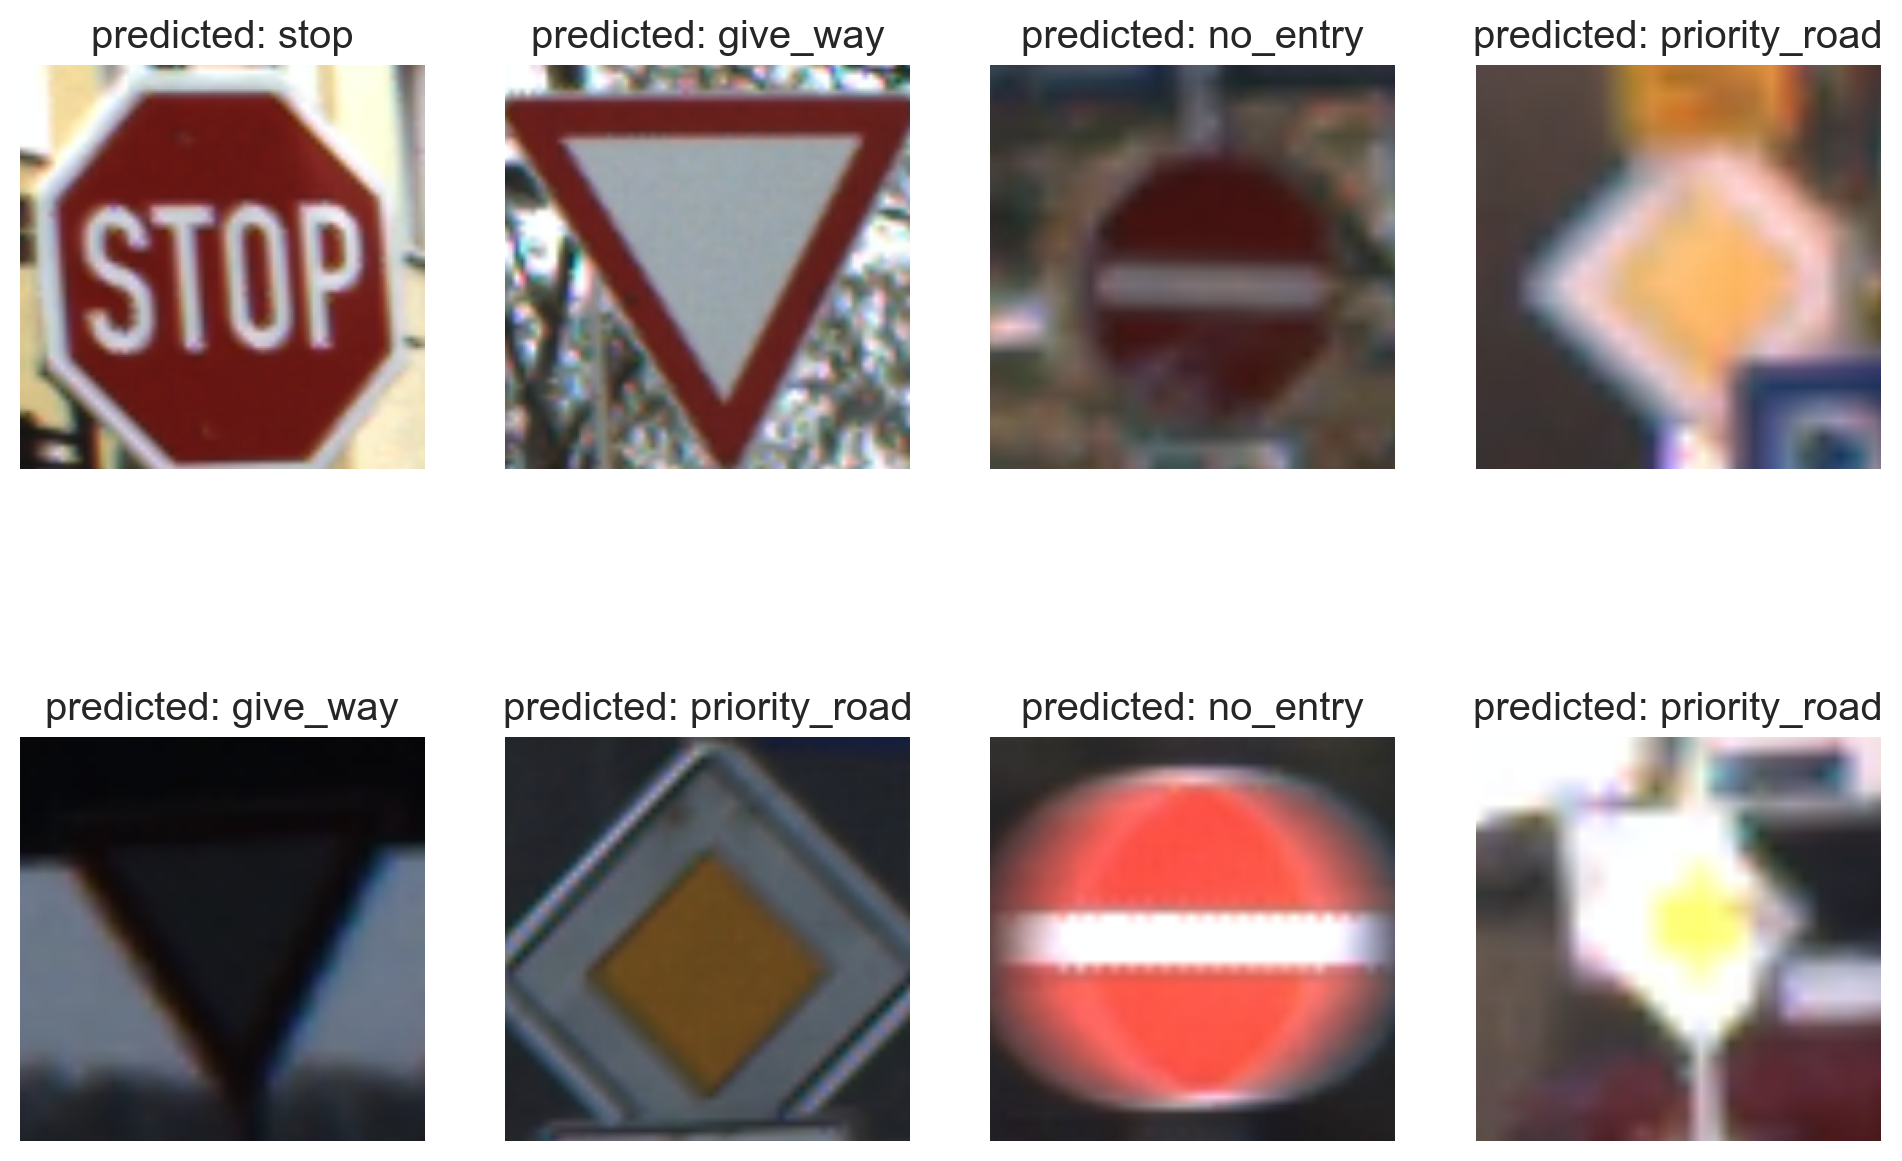

In [24]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')
        if images_handeled == n_images:
          return
show_predictions(base_model, class_names, n_images=8)

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [ ]:
y_pred, y_test = get_predictions(base_model, data_loaders['test'])
print(classification_report(y_test, y_pred, target_names=class_names))

ef show_confusion_matrix(confusion_matrix, class_names):
  cm = confusion_matrix.copy()
  cell_counts = cm.flatten()
  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]
  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]
  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])
  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)
  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)